# Mental Health in Tech Project

## Data Sets

[OSMI Survey on Mental Health in the Tech Workplace in 2014](https://www.kaggle.com/osmi/mental-health-in-tech-survey) 

["Ongoing" OSMI survey from 2016](https://www.kaggle.com/osmi/mental-health-in-tech-2016)


## Questions

## Exploring and Cleaning 2014 Data

In [161]:
import pandas as pd
% matplotlib inline

In [2]:
df14 = pd.read_csv("./datasets/2014/mental-health-in-tech-2014.csv")
print df14.shape
# df14.head(3)

(1259, 27)


In [83]:
# standardize columns to have lowercase names
df14.rename(columns={'Age': 'age', 'Gender': 'gender', 'Country': 'country', 'Timestamp': 'timestamp'}, inplace=True)
# replace confusing no_employees column name
df14.rename(columns={'no_employees': 'num_employees'}, inplace=True)
df14.head(3)

,timestamp,age,gender,country,state,self_employed,family_history,treatment,work_interfere,num_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37.0,Female,United States,IL,NaN,0,1,often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,0,NaN
1,2014-08-27 11:29:37,44.0,M,United States,IN,NaN,0,0,rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,0,NaN
2,2014-08-27 11:29:44,32.0,Male,Canada,NaN,NaN,0,0,rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,0,NaN


In [4]:
df_original = pd.read_csv("./datasets/2014/osmi-mental-health-in-tech-original.csv")
print df_original.shape
# print df_original.columns   # original questions/fields

(1259, 27)


<details><summary> Click to expand all **original questions/fields** </summary>
    
- Timestamp   
- Age  
- Gender   
- Country  
- If you live in the United States, which state or territory do you live in?  
- Are you self-employed?  
- Do you have a family history of mental illness?  
- Have you sought treatment for a mental health condition?  
- If you have a mental health condition, do you feel that it interferes with your work?  
- How many employees does your company or organization have?  
- Do you work remotely (outside of an office) at least 50% of the time?  
- Is your employer primarily a tech company/organization?  
- Does your employer provide mental health benefits?  
- Do you know the options for mental health care your employer provides?  
- Has your employer ever discussed mental health as part of an employee wellness program?  
- Does your employer provide resources to learn more about mental health issues and how to seek help?  
- Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?  
- How easy is it for you to take medical leave for a mental health condition?  
- Do you think that discussing a mental health issue with your employer would have negative consequences?  
- Do you think that discussing a physical health issue with your employer would have negative consequences?  
- Would you be willing to discuss a mental health issue with your coworkers?  
- Would you be willing to discuss a mental health issue with your direct supervisor(s)?  
- Would you bring up a mental health issue with a potential employer in an interview?  
- Would you bring up a physical health issue with a potential employer in an interview?  
- Do you feel that your employer takes mental health as seriously as physical health?  
- Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?  
- Any additional notes or comments
</details>

In [84]:
# create reference to look up questions based on column names
column_names = df14.columns
questions = df_original.columns
col_question_map = { 
    column_names[i]: questions[i] for i in range(df_original.shape[1]-1) 
}

# for example:
col_question_map['mental_vs_physical']

'Do you feel that your employer takes mental health as seriously as physical health?'

### Invalid ages

Ages range from `-1726` to `99999999999`.  This is supposed to be a survey of working adults, so values under 16 and over 100 can be ignored.

In [6]:
ages = df14.age.unique()
ages.sort()
print ages

[      -1726         -29          -1           5           8          11
          18          19          20          21          22          23
          24          25          26          27          28          29
          30          31          32          33          34          35
          36          37          38          39          40          41
          42          43          44          45          46          47
          48          49          50          51          53          54
          55          56          57          58          60          61
          62          65          72         329 99999999999]


In [7]:
nan = float('NaN')

df14.age = df14.age.map(lambda x: nan if (x<16 or x>100) else x)

In [8]:
# ages = df14.age.unique()
# ages.sort()
# print ages

### Gender responses

Gender responses seem to be strings entered by the user. To create a more manageable set of variables, I examine all the gender responses and categorize them into `female`, `male`, or `other`.  

Note (and it's noted in a comment in the code) that trans men and women map to `male` and `female` categories, respectively. Gender identity can have an impact on feelings of being stigmatized, so this might be a decision to explore further. 

In [9]:
# create dictionary to organize dummy data frames throughout
dummy_dfs = {}

In [10]:
print df14.gender.unique()

['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous' 'Male '
 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means']


In [11]:
# categorize gender responses into male, female, other based on response
def categorize_gender(gender_response):
    gender_response = gender_response.strip().lower()
    
    # caution - removing data about gender identity that may 
        # be correlated with mental health or feelings of being stigmatized
    male_responses = set(['male', 'm', 'man', 'cis male', 'male (cis)',
                          'trans-female', 'male (trans)', 'cis man',
                          'mal', 'mail', 'maile', 'make', 'msle', 'malr'])
    
    # caution - removing data about gender identity that may 
        # be correlated with mental health or feelings of being stigmatized
    female_responses = set(['female', 'f', 'woman', 'female (cis)', 
                            'trans-female', 'trans woman', 'female (trans)', 
                            'cis-female/femme', 'cis female', 
                            'femake', 'femail'])
    if gender_response in male_responses:
        return 'male'
    elif gender_response in female_responses:
        return 'female'
    else:
        return 'other'

# values mapped to 'other' for this data set:
#        ['male-ish', 'something kinda male?',
#        'queer/she/they', 'non-binary', 'nah', 'all', 'enby', 'fluid',
#        'genderqueer', 'androgyne', 'agender', 'guy (-ish) ^_^',
#        'male leaning androgynous', 'neuter', 'queer',
#        'a little about you', 'p',
#        'ostensibly male, unsure what that really means']

In [12]:
categorized_gender_responses = df14.gender.map(categorize_gender)

In [13]:
categorized_gender_responses.value_counts(dropna=False)

male      991
female    250
other      18
Name: gender, dtype: int64

In [14]:
dummy_dfs['gender'] = pd.get_dummies(categorized_gender_responses, prefix='gender')

### Yes/no questions

Many of the survey questions are yes/no questions, but the data is currently stored as strings. I convert these to `1` for `Yes` and `0` for `No`.

Most of the columns with three reponses have `'Yes'`, `'No'`, and `'Maybe'`, `'Don't know'`, or some other meaningful third option.  Those will be one-hot coded with dummy variables later.

In [15]:
for col in df14.columns:
    col_uniq = df14[col].unique()
    if len(col_uniq) == 2:
        print col, col_uniq

family_history ['No' 'Yes']
treatment ['Yes' 'No']
remote_work ['No' 'Yes']
tech_company ['Yes' 'No']
obs_consequence ['No' 'Yes']


In [16]:
def yes_no_same(response):
    if response=='Yes' or response==1:
        return 1
    elif response=='No' or response==0:
        return 0
    else:
        return response

In [17]:
def yes_no_same_column(df, column_name):
    df[column_name] = df[column_name].map(yes_no_same)

In [18]:
two_opt_cols = ['family_history', 'treatment', 'remote_work', 'tech_company', 'obs_consequence']
for col in two_opt_cols:
    yes_no_same_column(df14, col)

In [19]:
df14[two_opt_cols].head(3)

,family_history,treatment,remote_work,tech_company,obs_consequence
0,0,1,0,1,0
1,0,0,0,0,0
2,0,0,0,1,0


### Yes/no/maybe and other three-option columns

Many of the survey questions have yes/no/maybe or other meaningful third choices.  These columns will need one-hot coding and dummy variables.

In [20]:
three_opt_cols = [col for col in df14.columns if len(df14[col].unique()) == 3]

for col in three_opt_cols:
    print col, df14[col].unique()

self_employed [nan 'Yes' 'No']
benefits ['Yes' "Don't know" 'No']
care_options ['Not sure' 'No' 'Yes']
wellness_program ['No' "Don't know" 'Yes']
seek_help ['Yes' "Don't know" 'No']
anonymity ['Yes' "Don't know" 'No']
mental_health_consequence ['No' 'Maybe' 'Yes']
phys_health_consequence ['No' 'Yes' 'Maybe']
coworkers ['Some of them' 'No' 'Yes']
supervisor ['Yes' 'No' 'Some of them']
mental_health_interview ['No' 'Yes' 'Maybe']
phys_health_interview ['Maybe' 'No' 'Yes']
mental_vs_physical ['Yes' "Don't know" 'No']


The self-employed column is a special case with some missing values. The rest of the three-option columns have three choices from which users selected.  I'll quickly handle the self-employment data by treating this as a boolean (like the two-option columns) with some missing values.

In [21]:
yes_no_same_column(df14, 'self_employed')
df14.self_employed.value_counts(dropna=False)

 0.0    1095
 1.0     146
NaN       18
Name: self_employed, dtype: int64

#### Care Options

In [23]:
print col_question_map['care_options']
print df14['care_options'].value_counts(dropna=False)

Do you know the options for mental health care your employer provides?
No          501
Yes         444
Not sure    314
Name: care_options, dtype: int64


In [41]:
def get_prefix(response):
    if type(response) != str:
        return response
    else:
        return response.lower().replace(" ", "_").replace("'", "")

In [42]:
# # @TODO explanatory comment
# def format_y_n_other(df, col_name, other_dict):
#     def format_response(response):
#         if response in ['Yes', 'No', 'yes', 'no']:
#             return response.lower()
#         elif response in other_dict:
#             return other_dict[response]
#         else:
#             # if already replaced (response in other_dict.values())
#             # or if completely unrecognized
#             return response
#     df[col_name] = df[col_name].map(format_response)

In [43]:
df14['care_options'] = df14['care_options'].map(get_prefix)
print df14.care_options.unique()

['not_sure' 'no' 'yes']


#### Other "Three Option" Columns

In [44]:
# dontknow_cols = ['benefits', 'wellness_program', 'seek_help', 'anonymity', 
#            'mental_vs_physical']
# for col in dontknow_cols:
#     format_y_n_other(df14, col, { "Don't know": 'dontknow' })
    
# maybe_cols = ['mental_health_consequence', 'phys_health_consequence',
#             'mental_health_interview', 'phys_health_interview']
# for col in maybe_cols:
#     format_y_n_other(df14, col, { 'Maybe': 'maybe' })

# some_cols = ['coworkers', 'supervisor']        
# for col in some_cols:
#     format_y_n_other(df14, col, { 'Some of them': 'some' })           
three_opt_cols

['self_employed',
 'benefits',
 'care_options',
 'wellness_program',
 'seek_help',
 'anonymity',
 'mental_health_consequence',
 'phys_health_consequence',
 'coworkers',
 'supervisor',
 'mental_health_interview',
 'phys_health_interview',
 'mental_vs_physical']

In [45]:
a = df14.copy()
for col in three_opt_cols:
    a[col] = a[col].map(get_prefix)
    print a[col].unique()

[ nan   1.   0.]
['yes' 'dont_know' 'no']
['not_sure' 'no' 'yes']
['no' 'dont_know' 'yes']
['yes' 'dont_know' 'no']
['yes' 'dont_know' 'no']
['no' 'maybe' 'yes']
['no' 'yes' 'maybe']
['some_of_them' 'no' 'yes']
['yes' 'no' 'some_of_them']
['no' 'yes' 'maybe']
['maybe' 'no' 'yes']
['yes' 'dont_know' 'no']


In [46]:
if three_opt_cols[0] == 'self_employed':
    three_opt_cols.pop(0)
for col in three_opt_cols:
    dummy_dfs[col] = pd.get_dummies(df14[col], prefix=col)

In [47]:
dummy_dfs.keys()

['wellness_program',
 'benefits',
 'seek_help',
 'gender',
 'mental_vs_physical',
 'care_options',
 'phys_health_interview',
 'coworkers',
 'mental_health_consequence',
 'anonymity',
 'supervisor',
 'mental_health_interview',
 'phys_health_consequence']

**At this point**, the `dummy_dfs` dictionary holds dummy variable sets for all three-option columns as well as `gender`.

### Other categorical variables

In [49]:
# quick NaN check
counts = df14.count()
numrows = df14.shape[0]
for col in df14.columns:
    if counts[col] != numrows:
        print "{0} has {1} NaNs".format(col, numrows-counts[col])

age has 8 NaNs
state has 515 NaNs
self_employed has 18 NaNs
work_interfere has 264 NaNs
comments has 1095 NaNs


#### Country & State

In [61]:
countries = df14['country'].map(get_prefix)
print countries.head(3)

0    united_states
1    united_states
2           canada
Name: country, dtype: object


In [62]:
dummy_dfs['country'] = pd.get_dummies(countries)
# dummy_dfs['country'].head(3)

In [63]:
dummy_dfs['state'] = pd.get_dummies(df14.state, prefix='state', dummy_na=True)
dummy_dfs['state'].head(3)
# baseline is nan states

,state_AL,state_AZ,state_CA,state_CO,state_CT,state_DC,state_FL,state_GA,state_IA,state_ID,...,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,state_nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### If you have a mental health condition, do you feel that it interferes with your work?

In [64]:
print col_question_map['work_interfere']
df14['work_interfere'].value_counts(dropna=False)

If you have a mental health condition, do you feel that it interferes with your work?


Sometimes    465
NaN          264
Never        213
Rarely       173
Often        144
Name: work_interfere, dtype: int64

In [79]:
df14['work_interfere'] = df14['work_interfere'].map(get_prefix)
# df14['work_interfere'].value_counts(dropna=False)

In [80]:
dummy_dfs['work_interfere'] = pd.get_dummies(
    df14.work_interfere, 
    prefix='work_interfere',
    dummy_na=True   # singificant amount of rows with this data missing
)

#### How many employees does your company or organization have?

In [107]:
print col_question_map['num_employees']
df14.num_employees.value_counts(dropna=False)

How many employees does your company or organization have?


6-25        290
26-100      289
1000+       282
100-500     176
1-5         162
500-1000     60
Name: num_employees, dtype: int64

In [108]:
df14.num_employees = df14.num_employees.map(lambda x: '1000+' if x=='More than 1000' else x)
print df14.num_employees.unique()

['6-25' '1000+' '26-100' '100-500' '1-5' '500-1000']


In [109]:
dummy_dfs['num_employees'] = pd.get_dummies(df14.num_employees, prefix='num_employees')
# dummy_dfs['num_employees'].head(3)

#### How easy is it for you to take medical leave for a mental health condition?

In [110]:
print col_question_map['leave']
df14.leave.value_counts(dropna=False)

How easy is it for you to take medical leave for a mental health condition?


dont_know             563
somewhat_easy         266
very_easy             206
somewhat_difficult    126
very_difficult         98
Name: leave, dtype: int64

In [112]:
df14.leave = df14.leave.map(get_prefix)
print df14.leave.unique()

['somewhat_easy' 'dont_know' 'somewhat_difficult' 'very_difficult'
 'very_easy']


In [113]:
dummy_dfs['leave'] = pd.get_dummies(df14.leave, prefix='leave')
# dummy_dfs['leave'].head(2)

### Timestamps

Timestamps are time series data. Mostly ignoring them for now.

In [143]:
first = df14.timestamp.min()
last = df14.timestamp.max()
print first
print last

2014-08-27 11:29:31
2016-02-01 23:04:31


In [157]:
first = pd.to_datetime(first)
last = pd.to_datetime(last)
last - first

Timedelta('523 days 11:35:00')

In [159]:
df14['timestamp'] = df14['timestamp'].map(pd.to_datetime)

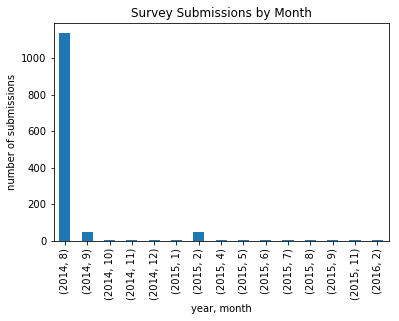

In [187]:
# using family_history (which has no NaNs as a standin for total submissions)
submit_date_counts = df14['family_history'].groupby([df14['timestamp'].dt.year, df14['timestamp'].dt.month]).count()
p = submit_date_counts.plot(kind='bar', title='Survey Submissions by Month')
p.set_xlabel('year, month')
p.set_ylabel('number of submissions')

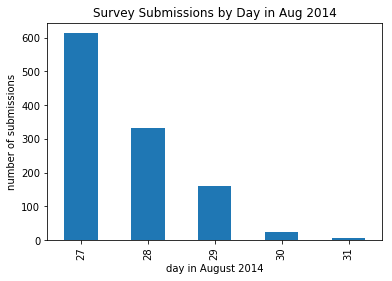

In [212]:
# using family_history (which has no NaNs as a standin for total submissions)
aug14 = df14[(df14['timestamp'].dt.year==2014)]
aug14 = aug14[(aug14['timestamp'].dt.month==8)]
submit_date_counts = aug14['family_history'].groupby(aug14['timestamp'].dt.day).count()
p = submit_date_counts.plot(kind='bar', title='Survey Submissions by Day in Aug 2014')
p.set_xlabel('day in August 2014')
p.set_ylabel('number of submissions')
# aug14_subs

Most of the survey data was collected over 2-3 days in August, 2014.

### Comments
Comments are natural language. Ignoring them for now.

In [218]:
num_comments = df14.comments.count()
print num_comments
print df14.shape[0] - num_comments
print aug14.comments.count()

164
1095
147


## A Model


In [235]:
# dummies = dummy_dfs.keys()
# print dummies
# feature_count = df14.shape[1]
# for key in dummies:
#     feature_count += dummy_dfs[key].shape[1]
# print feature_count
print df14.columns

Index([u'timestamp', u'age', u'gender', u'country', u'state', u'self_employed',
       u'family_history', u'treatment', u'work_interfere', u'num_employees',
       u'remote_work', u'tech_company', u'benefits', u'care_options',
       u'wellness_program', u'seek_help', u'anonymity', u'leave',
       u'mental_health_consequence', u'phys_health_consequence', u'coworkers',
       u'supervisor', u'mental_health_interview', u'phys_health_interview',
       u'mental_vs_physical', u'obs_consequence', u'comments'],
      dtype='object')


In [226]:
df = df14.copy()

In [234]:
col_question_map['num_employees']

'How many employees does your company or organization have?'

In [236]:
col_question_map['tech_company']

'Is your employer primarily a tech company/organization?'

In [248]:
X = pd.concat([df[['tech_company']], dummy_dfs['num_employees'], dummy_dfs['country']], axis=1)
X.head(2)

,tech_company,num_employees_1-5,num_employees_100-500,num_employees_1000+,num_employees_26-100,num_employees_500-1000,num_employees_6-25,australia,austria,"bahamas,_the",...,slovenia,south_africa,spain,sweden,switzerland,thailand,united_kingdom,united_states,uruguay,zimbabwe
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [251]:
col_question_map


{'age': 'Age',
 'anonymity': 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?',
 'benefits': 'Does your employer provide mental health benefits?',
 'care_options': 'Do you know the options for mental health care your employer provides?',
 'country': 'Country',
 'coworkers': 'Would you be willing to discuss a mental health issue with your coworkers?',
 'family_history': 'Do you have a family history of mental illness?',
 'gender': 'Gender',
 'leave': 'How easy is it for you to take medical leave for a mental health condition?',
 'mental_health_consequence': 'Do you think that discussing a mental health issue with your employer would have negative consequences?',
 'mental_health_interview': 'Would you bring up a mental health issue with a potential employer in an interview?',
 'mental_vs_physical': 'Do you feel that your employer takes mental health as seriously as physical health?',
 'num_employees': 'How many employee

In [230]:
col_question_map['mental_health_consequence']

'Do you think that discussing a mental health issue with your employer would have negative consequences?'

In [250]:
y = df['mental_health_consequence']